# Basic Component Separation Using Scattering Covariance

This notebook provides a simplified example of how to use **scattering covariance** to distinguish between the **CMB** and the **signal of interest**.

---

## Data Model

We assume the observed data map $d$ is given by:

$$
d = s + c
$$

- $s$: a dust map (from [SRoll30 857 GHz data](ftp://sroll20.ias.u-psud.fr/sroll30_857/SRoll30_SkyMap_857-1_full.fits))  
- $c$: a CMB map, simulated with the **CAMB** package using Planck parameters  

We consider $n_{\text{cmb}} = 100$ CMB realizations.

---

## Loss Functions

Two loss functions are defined:

$$
L_1 = \sum_{i=1}^{n_{\text{cmb}}} 
      \frac{\big(\Phi(d) - \Phi(s + c_i)\big)^2}{\sigma_n^2}
$$

$$
L_2 = \sum_{i=1}^{n_{\text{cmb}}} 
      \frac{\big(\Phi(d,s) - \Phi(s + c_i, s)\big)^2}{\sigma_x^2}
$$

- $\Phi(\cdot)$: scattering covariance operator  
- $\sigma_n, \sigma_x $: normalization terms  

The method alternates between two types of iterations, jointly minimizing $L_1$ and $L_2$.

---

## Extensions

Users are encouraged to add **additional loss terms** to improve component separation.  
For example:

- Incorporating a **mask** is essential, since the problem is not stationary on the sphere (due to strong Galactic emission near the equator).  
- Other constraints can be included depending on the target application.

---

## Practical Notes

- The quality of the component separation depends on the number of CMB noise realizations.  
- This number is limited by **GPU memory**.  
- You can adjust it in *cell 2* of the notebook to achieve better results (at higher computational cost).

---


In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import foscat.Synthesis as synthe

## Initialize data

The signal of interest is a 2D smiley picture downgraded to xsize=64 to make it run faster. The value range is [0,1].

In [2]:
nside=32
# number of noise to learn statistics
ncmb=10

# Compute CMB pictures

In [3]:
import camb
import healpy as hp
from camb import model, initialpower

class gen_cmb:
    def __init__(self,nside):
        self.nside = nside # résolution de la carte (higher nside = higher resolution)
        self.lmax = 3 * nside  # ell maximum
        self.seed = 42  # pour reproductibilité

        # Fixe le modèle cosmologique ΛCDM (paramètres Planck 2018-like)
        self.pars = camb.CAMBparams()
        self.pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122,tau=0.054)
        self.pars.InitPower.set_params(As=2e-9, ns=0.965)
        self.pars.set_for_lmax(self.lmax, lens_potential_accuracy=0)
        self.pars.WantTensors = True
        
    def get(self,tau=0.058, r=0.0,seed=None):
        # Génère les spectres de puissance
        self.pars.Reion.optical_depth = tau
        self.pars.InitPower.r = r
        results = camb.get_results(self.pars)
        powers = results.get_cmb_power_spectra(self.pars, CMB_unit='muK')

        # On récupère les Cls pour le CMB primordial sans effet secondaire
        totCL = powers['total']
        cls = totCL[:self.lmax + 1, :3]  # On prend TT, EE, BB

        # Prépare les Cls pour healpy (Dl -> Cl convention : Dl = l(l+1)Cl/2pi)
        # healpy veut Cl non normalisé
        w=(2*np.pi)/(np.arange(self.lmax+1)*(np.arange(self.lmax+1)+1))
        w[0]=1.0
        cl_tt = cls[:, 0]*w
        cl_ee = cls[:, 1]*w
        cl_bb = cls[:, 2]*w
        cl_te = totCL[:self.lmax + 1, 3]*w

        # --- Génération des cartes ---
        if seed is not None:
            self.seed=seed
        np.random.seed(self.seed)
        self.seed+=1

        np.random.seed(self.seed)
        alm = hp.synalm([cl_tt, cl_ee, cl_bb, cl_te], lmax=self.lmax, new=True)

        # Convertir les alms en cartes T, Q, U
        return hp.alm2map(alm, nside=self.nside, pol=True)

In [4]:
try:
    cmb_maps=np.load('data/cmb_maps_%d_%d.npy'%(ncmb,nside))
except:
    gcmb=gen_cmb(nside)
    
    cmb_maps=np.zeros([ncmb,12*nside**2])
    
    for k in range(ncmb):
        if k%10==9:
            print(k)
        maps=gcmb.get()
        cmb_maps[k]=maps[0]
    
    np.save('data/cmb_maps_%d_%d.npy'%(ncmb,nside),cmb_maps)
    
    cmb_maps=np.load('data/cmb_maps_%d_%d.npy'%(ncmb,nside)) 

for k in range(ncmb):
    cmb_maps[k]=hp.reorder(cmb_maps[k],r2n=True)

In [5]:
try:
    im=np.load('Dust_%d.npy'%(nside))
except:
    im=hp.read_map('ftp://sroll20.ias.u-psud.fr/sroll30_857/SRoll30_SkyMap_857-1_full.fits')
    im=hp.ud_grade(im,nside)
    im=hp.reorder(im,r2n=True)
    np.save('Dust_%d.npy'%(nside),im)
    im=np.load('Dust_%d.npy'%(nside))

# compute data to clean

/tmp/ipykernel_10670/4155651767.py:31: RuntimeWarning: divide by zero encountered in divide
  w=(2*np.pi)/(np.arange(self.lmax+1)*(np.arange(self.lmax+1)+1))


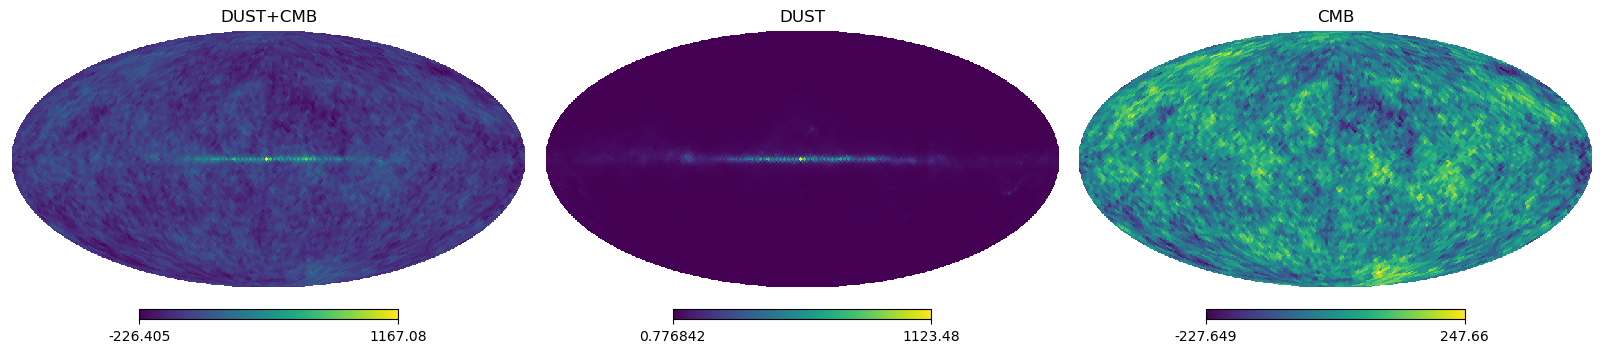

In [6]:
gcmb=gen_cmb(nside)
    
maps=gcmb.get()

cmb_im = hp.reorder(maps[0],r2n=True)
data   = im + cmb_im

plt.figure(figsize=(16,4))
hp.mollview(data,nest=True,sub=(1,3,1),hold=False,title='DUST+CMB')
hp.mollview(im,nest=True,sub=(1,3,2),hold=False,title='DUST')
hp.mollview(cmb_im,nest=True,sub=(1,3,3),hold=False,title='CMB')

# Define the Scaterring Covariance statistics

In [7]:
import foscat.scat_cov as sc

scat_op=sc.funct(KERNELSZ=5)

## define the statistics

the eval_scat function defines how the statistics are computed using foscat.

In [8]:
# \Phi(d) \simeq \Phi(u + n),
def The_loss(x,scat_operator,args,return_all=False):

    ref  = args[0]
    noise= args[1]

    learn=scat_operator.eval(x+noise)
    
    # compute the mean scattering covariance of the current synthetised maps called u
    learn=scat_operator.reduce_mean_batch(learn)
    
    # make the difference with the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref)
    return loss

# \Phi(d,u) \simeq \Phi(u + n,u),
def The_lossX(x,scat_operator,args,return_all=False):

    im   = args[0]
    noise= args[1]
    ref=scat_operator.eval(im,
                           image2=x)

    learn=scat_operator.eval(x+noise,
                             image2=x.expand(noise.shape[0],-1))

    # compute the mean scattering covariance of the current synthetised maps called u
    learn=scat_operator.reduce_mean_batch(learn)
    
    # make the difference with the reference coordinates
    loss=scat_operator.reduce_distance(learn,ref)
    return loss

ref=scat_op.eval(data)

in_data=scat_op.backend.bk_cast(data[None,:])

loss=synthe.Loss(The_loss,
                 scat_op,
                 ref,
                 scat_op.backend.bk_cast(cmb_maps))

lossX=synthe.Loss(The_lossX,
                  scat_op,
                  scat_op.backend.bk_cast(data[None,:]),
                  scat_op.backend.bk_cast(cmb_maps))

# define the foscat synthesis using the two previous loss
sy = synthe.Synthesis([loss,lossX])

clean_map=sy.run(in_data,EVAL_FREQUENCY=10,NUM_EPOCHS = 100)

clean_map=scat_op.to_numpy(clean_map)

/srv/conda/envs/notebook/lib/python3.12/site-packages/foscat/BkTorch.py:349: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1750199048837/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return self.backend.sparse_coo_tensor(indice.T, w, dense_shape).to_sparse_csr().to(self.torch_device)
/srv/conda/envs/notebook/lib/python3.12/site-packages/foscat/BkTorch.py:768: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /home/conda/feedstock_root/build_artif

Total number of loss  2
Itt      0 L=      56.1 (       111      0.857 ) 1.523s 
Itt     10 L=     0.433 (     0.401      0.465 ) 18.680s 
Itt     20 L=    0.0827 (     0.105     0.0606 ) 11.625s 
Itt     30 L=    0.0531 (    0.0741      0.032 ) 12.522s 
Itt     40 L=    0.0452 (    0.0626     0.0278 ) 10.360s 
Itt     50 L=    0.0427 (    0.0601     0.0253 ) 4.836s 
Itt     60 L=    0.0412 (    0.0581     0.0243 ) 4.528s 
Itt     70 L=    0.0406 (    0.0571     0.0241 ) 4.542s 
Itt     80 L=    0.0402 (    0.0567     0.0237 ) 4.561s 
Itt     90 L=      0.04 (    0.0564     0.0237 ) 5.021s 
Itt    100 L=    0.0399 (    0.0561     0.0237 ) 5.456s 
Final Loss  0.03991040214896202


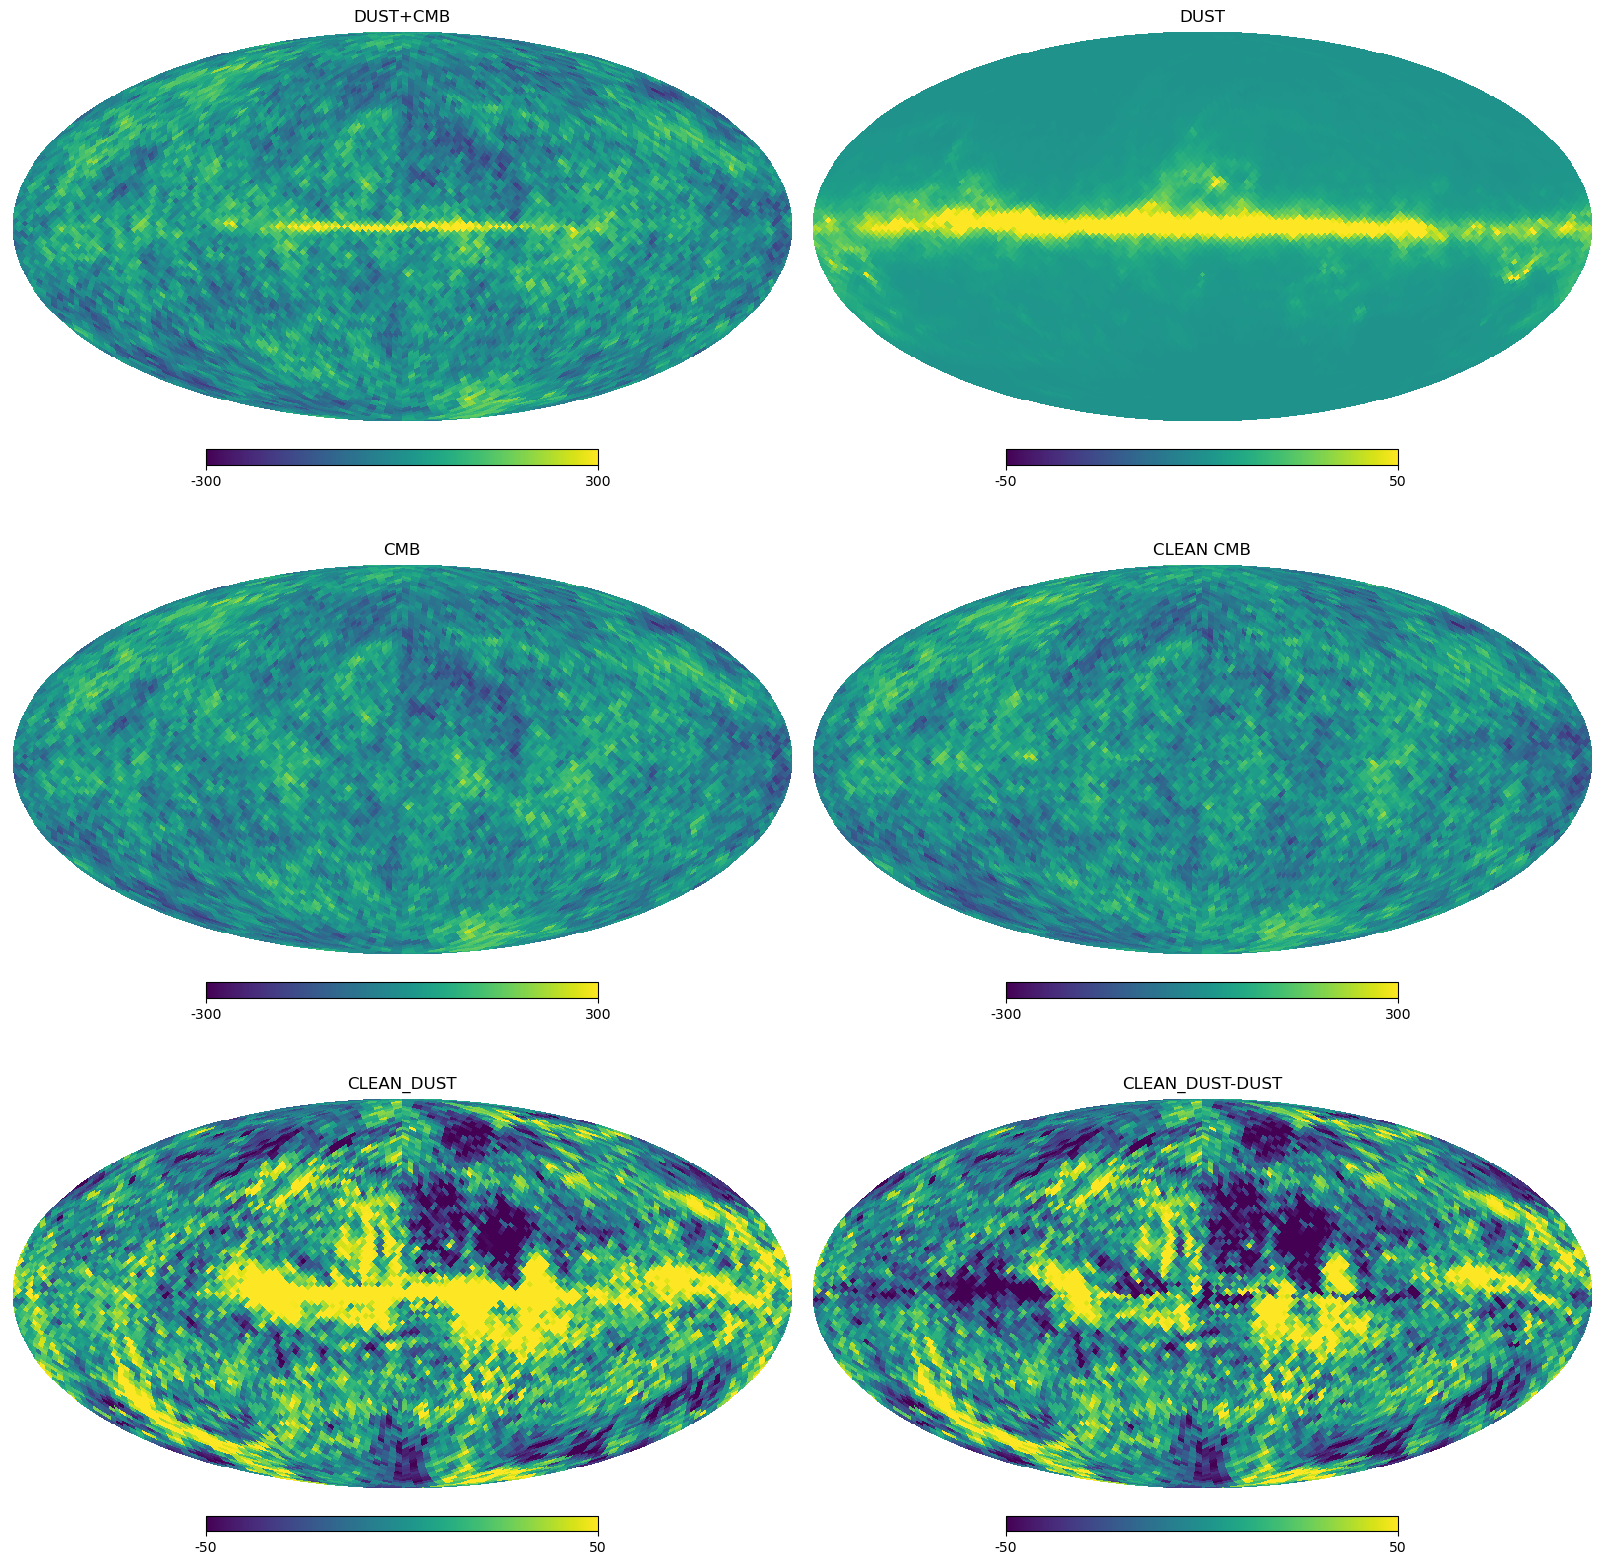

In [9]:
plt.figure(figsize=(16,16))
hp.mollview(data,nest=True,sub=(3,2,1),hold=False,title='DUST+CMB',min=-300,max=300)
hp.mollview(im,nest=True,sub=(3,2,2),hold=False,title='DUST',min=-50,max=50)
hp.mollview(cmb_im,nest=True,sub=(3,2,3),hold=False,title='CMB',min=-300,max=300)
hp.mollview(data-clean_map[0],nest=True,sub=(3,2,4),hold=False,title='CLEAN CMB',min=-300,max=300)
hp.mollview(clean_map[0],nest=True,sub=(3,2,5),hold=False,title='CLEAN_DUST',min=-50,max=50)
hp.mollview(clean_map[0]-im,nest=True,sub=(3,2,6),hold=False,title='CLEAN_DUST-DUST',min=-50,max=50)


In [10]:
cl_data=hp.anafast(hp.reorder(data,n2r=True))
cl_clean=hp.anafast(hp.reorder(clean_map[0],n2r=True))
cl_dust=hp.anafast(hp.reorder(im,n2r=True))
cl_clean_cmb=hp.anafast(hp.reorder(data-clean_map[0],n2r=True))
cl_cmb=hp.anafast(hp.reorder(cmb_im,n2r=True))
cl_residu=hp.anafast(hp.reorder(im-clean_map[0],n2r=True))

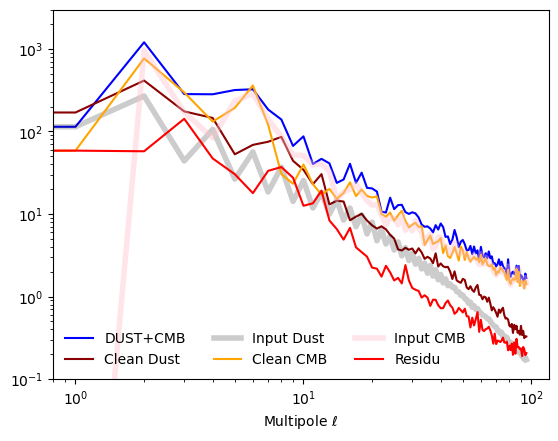

In [11]:
plt.plot(cl_data,color='b',label='DUST+CMB')
plt.plot(cl_clean,color='darkred',label='Clean Dust')
plt.plot(cl_dust,color='black',lw=4,alpha=0.2,label='Input Dust')
plt.plot(cl_clean_cmb,color='orange',label='Clean CMB')
plt.plot(cl_cmb,color='pink',label='Input CMB',alpha=0.4,lw=4)
plt.plot(cl_residu,color='r',label='Residu')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Multipole $\ell$')
plt.ylim(1E-1,3E3)
plt.legend(frameon=0,ncols=3)